## Brand Value and Customer's Reflection

Goal: By comparing user comments to keywords, we will evaluate the alignment of the brand's mission statements (how they intend to potray themselves) to user's perception of their brands. We aim to quantify how much consumers reflect the brand's values. 

The alignment is calculated using TF-IDF alignment score and cosine similarity



In [14]:
import pandas as pd
import numpy as np
import spacy
from scipy.stats import zscore
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity 
import seaborn as sns
import matplotlib.pyplot as plt
import os

data_path = "../../../data/alignment_analysis/"
output_path = "../../../output/alignment_analysis/"
if not os.path.exists(output_path):
    os.makedirs(output_path)


In [2]:
#Loading the data
brand_value = pd.read_csv("../../../data/brand_values.csv")
user_comment = pd.read_csv(data_path + "subreddit_comment_data.csv")
print(user_comment.shape)
brand_value.columns = brand_value.columns.str.strip().str.lower()
user_comment.columns = user_comment.columns.str.strip().str.lower()


user_comment = user_comment[user_comment["brand"].notna()]

user_comment["brand"].unique()

brand_mapping = {
    'fenty': 'Fenty Beauty',
    'Fenty': 'Fenty Beauty',
    'etude': 'Etude House',
    'e.l.f.': 'e.l.f. Cosmetics',
    'Etude': 'Etude House',
    'elf': 'e.l.f. Cosmetics', 
    'Tarte': 'Tarte Cosmetics'
}
user_comment["brand"] = user_comment["brand"].replace(brand_mapping) 
user_comment = user_comment.dropna(subset=["brand"])

def normalize_brand(name):
    return brand_mapping.get(name.lower().strip(), name.strip())

user_comment["normalized_brand"] = user_comment["brand"].apply(normalize_brand)

user_comment["brand"].unique()

(1304, 6)


array(['Estée Lauder', 'Fenty Beauty', 'e.l.f. Cosmetics',
       'Tarte Cosmetics', 'Glossier', 'Laneige', 'Sulwhasoo',
       'Etude House', 'Innisfree', 'COSRX'], dtype=object)

In [3]:
brand_value = brand_value.rename(columns={"brand": "search_term", "values/ mission": "brand_mission"})

new_df = user_comment.merge(
    brand_value[["search_term", "brand_mission"]],
    left_on="brand",
    right_on="search_term",
    how="inner"
)

new_df["brand"].unique()

array(['Estée Lauder', 'Fenty Beauty', 'e.l.f. Cosmetics',
       'Tarte Cosmetics', 'Glossier', 'Laneige', 'Sulwhasoo',
       'Etude House', 'Innisfree', 'COSRX'], dtype=object)

In [4]:
print(new_df.columns) 

Index(['post_id', 'title', 'brand', 'subreddit_name', 'comment',
       'cleaned_comment', 'normalized_brand', 'search_term', 'brand_mission'],
      dtype='object')


In [5]:
#Using TF-IDF alignment score 
#Term Frequency – Inverse Document Frequency 
# The text is converted into a vector of numbers, representing the importance of the words in the comment column and the brand_mission column 
# relative to each other 
#fit_transform builds a vocabulary from the strings "comment" and "brand_mission", then term frequency is computed for each one 
# Inverse-document frequencies are then computed based on the two texts

def get_alignment_score(row):
    key_columns = [str(row["brand_mission"]), str(row["comment"])]
    vectorizer = TfidfVectorizer(stop_words="english")
    tfidf = vectorizer.fit_transform(key_columns)
    return cosine_similarity(tfidf[0], tfidf[1])[0][0] 
    #1 is perfectly align 
    #0 is no alignment 

new_df["alignment_score"] = new_df.apply(get_alignment_score, axis = 1)

new_df["brand"].unique()


array(['Estée Lauder', 'Fenty Beauty', 'e.l.f. Cosmetics',
       'Tarte Cosmetics', 'Glossier', 'Laneige', 'Sulwhasoo',
       'Etude House', 'Innisfree', 'COSRX'], dtype=object)

In [6]:
#Summary Data 
new_df["z_score"] = new_df.groupby("brand")["alignment_score"].transform(zscore)

insight = new_df.groupby("brand").agg(
    mean_alignment = ("alignment_score", "mean"), 
    mean_z_alignment = ("z_score", "mean")).reset_index()

insight 

,brand,mean_alignment,mean_z_alignment
0,COSRX,0.014132,0.000000e+00
1,Estée Lauder,0.003133,-1.361594e-17
2,Etude House,0.011211,-6.581562e-17
3,Fenty Beauty,0.025618,-1.743806e-17
4,Glossier,0.013513,-1.067522e-18
5,Innisfree,0.004159,-4.351628e-17
6,Laneige,0.013219,-8.478067e-18
7,Sulwhasoo,0.017722,-1.747026e-17
8,Tarte Cosmetics,0.002288,2.065531e-17
9,e.l.f. Cosmetics,0.008806,-1.053289e-16


In [18]:
#Classify the alignment score into top alignments and create a new dataframe

top_alignment_comment = new_df.sort_values("alignment_score", ascending=False).drop_duplicates("brand")
top_alignment_comment["alignment_type"] = "Top Aligned"

low_alignment_comment = new_df.sort_values("alignment_score", ascending=True).drop_duplicates("brand")
low_alignment_comment["alignment_type"] = "Lowest Aligned"

both_df = pd.concat([top_alignment_comment, low_alignment_comment]).sort_values(["brand", "alignment_type"])

both_df[both_df["brand"] == "COSRX"]


,post_id,title,brand,subreddit_name,comment,cleaned_comment,normalized_brand,search_term,brand_mission,alignment_score,z_score,alignment_type
674,110wklo,"hi!! ever since starting differin im really drying out. i use the COSRX all in one snail cream + the vanicream lotion for my main moisturizers but i want to add a hydrating, skin barrier repairing serum OR toner into my routine. any recs? i live in canada so pls stuff that’s available in our sephora",COSRX,Sephora,The Paula’s choice replenishing toner is extremely hydrating,paula choice replenishing toner extremely hydrating,COSRX,COSRX,"COSRX believes that cosmetics should give more than just outward beauty. We are devoted to enabling individuals to find solutions according to their personal skin conditions. We strive to help our customers to gain self-confidence, and ultimately to find their own unique beauty inside.\nSince 2002 and finally, “Cosmetics + RX(Prescription) = COSRX” was founded in 2013. With skin-friendly ingredients that alleviate irritated skin, we want to provide a better tomorrow for our customers.",0.000000,-0.580132,Lowest Aligned
1296,1k5v4sc,Review of COSRX Snail Mucin Power Essence,COSRX,IndianSkincareAddicts,Can you please share your skin type ? And how you use it ?,type,COSRX,COSRX,"COSRX believes that cosmetics should give more than just outward beauty. We are devoted to enabling individuals to find solutions according to their personal skin conditions. We strive to help our customers to gain self-confidence, and ultimately to find their own unique beauty inside.\nSince 2002 and finally, “Cosmetics + RX(Prescription) = COSRX” was founded in 2013. With skin-friendly ingredients that alleviate irritated skin, we want to provide a better tomorrow for our customers.",0.111879,4.012581,Top Aligned


In [8]:
pd.set_option("display.max_colwidth", None)
top_alignment_comment[["comment", "brand", "brand_mission", "alignment_score"]]

,comment,brand,brand_mission,alignment_score
822,Age does not always correlate to skin type. I've always had dry skin and my friend is almost 50 still dealing with oily skin. Products are made for skin types.,Sulwhasoo,"Sulwhasoo believes that there is an innovative artist in all of us.\nWe explore our heritage for inspiration and create new things that\nchallenges and changes perspectives.\nWe drew upon our own heritage to create new products that we see as work of art as\nthey transcend time and generations. At Sulwhasoo, we believe in a holistic approach to skincare.\nGoing beyond addressing visible issues on the skin’s surface, Sulwhasoo looks deeply into the root causes of skin aging and addressing them at the source.\nOur definition of genuine skin solutions involves the recovery of skin’s rejuvenating system.\nWe believe that activating the skin’s potential is the first step towards achieving healthy-looking skin.\nFor this, Sulwhasoo presents the skincare routine, starting with First Care Activating Serum, formulated to activate your skin’s potential.",0.306119
294,Fenty!! It’s so underrated,Fenty Beauty,"FENTY BEAUTY: This is where Rihanna started it all, for all. More than just makeup, it’s a mission with a vision, serving foundation that put every tone on the map. Launching color that created new ways of being and seeing with loaded pigments and freestyle formulas. FENTY SKIN: Great skin makes great makeup. Start your base with Fenty Skin—smart, high-performance skincare with a clear mission: treat, smooth and tighten the look of pores, day and night, under makeup and over time. Never complicated, always clinical. FENTY HAIR: The radically transformative power of hair? Rihanna owns that. But serving looks and switchin’ styles can take its toll. Enter Fenty Hair: a new era of repair. It’s a line that infuses repair into every step for styles that won’t stop. Your hair on Fenty? It’s stronger by the style.",0.216879
1133,"Literally can't even tell where the makeup is, amazing! You're gorgeous!\n\nI haven't tried their products before but it doesn't seem like I'd get a match for olive skin :(",Glossier,"Before we launched Glossier in 2014, we started as Into The Gloss. A beauty website and community devoted to sharing real information with real people, about really amazing products. It’s where we realized that beauty shouldn’t be built in a boardroom—it should be built by you. This ethos gave birth to our philosophy: Skin First. Makeup Second™. We prioritize skincare because we believe that healthy skin is the best foundation. We believe in thoughtful design and cultivating conversations. It’s at the core of everything we do—the starting point of all our makeup, skincare, bodycare, and fragrance products. At Glossier, beauty is about celebrating freedom of expression, individuality , and having fun. Our Skin First. Makeup Second™ approach ensures that every product supports your skin’s health, allowing your makeup to enhance rather than mask your natural beauty.",0.163880
89,I have super dry skin and love it! I do feel it leaves a sticky layer but it also is quite hydrating and makes me look insanely dewy. I have built an HA-free routine and can vouch it is great for dry skin!,Laneige,"We aim to create multi-tasking products that make caring for your skin easy. Our team is fascinated by how to better hydrate skin and lips, and are dedicated to continuing to research the latest and greatest ingredients while using our innovative technology to create formulas that deliver visible results—offering the dewy, bouncy skin you love.",0.139533
1296,Can you please share your skin type ? And how you use it ?,COSRX,"COSRX believes that cosmetics should give more than just outward beauty. We are devoted to enabling individuals to find solutions according to their personal skin conditions. We strive to help our customers to gain self-confidence, and ultimately to find their own unique beauty inside.\nSince 2002 and finally, “Cosmet

## Visualization of Alignment Score
Comparision between Korean and US Brands 

In [9]:
# Categorize the brands base on country

insight["country"] = "US Brand"

korean_brands = ["COSRX", "Etude House", "Innisfree", "Laneige", "Sulwhasoo"]
insight.loc[
    insight["brand"].str.contains("|".join(korean_brands), case=False),
    "country"] = "Korean Brand" 

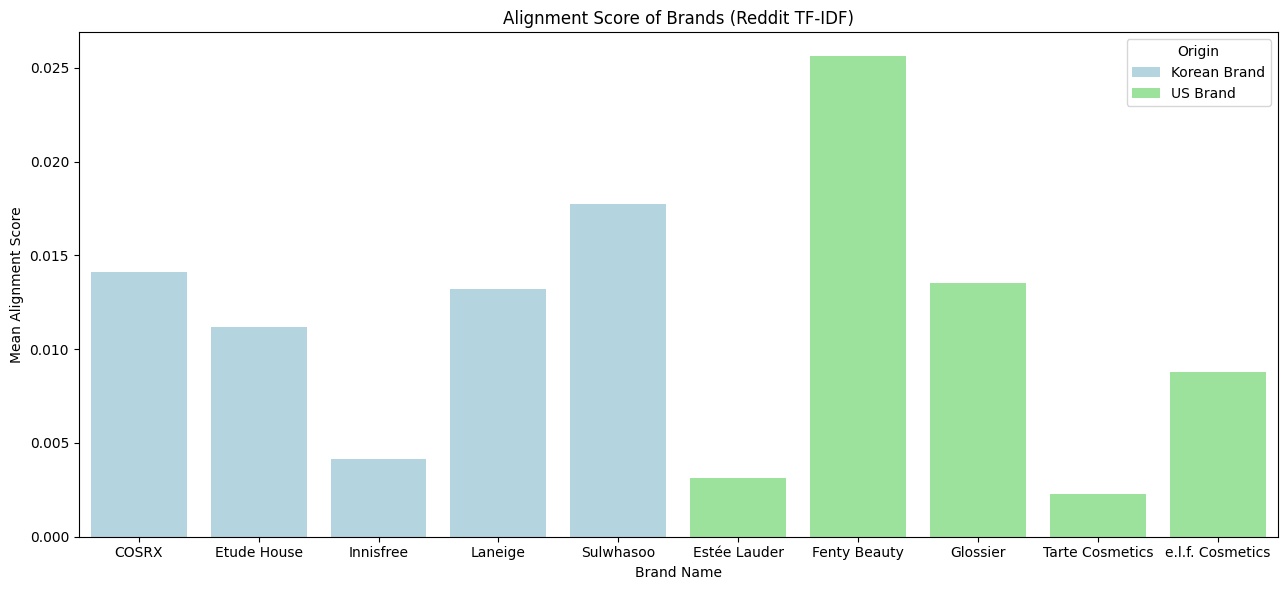

In [19]:
sorted_by_country = insight.sort_values(by=["country", "brand"])

plt.figure(figsize=(13, 6))
sns.barplot(data=sorted_by_country, x="brand", y="mean_alignment", hue="country", palette={"Korean Brand": "lightblue", "US Brand": "lightgreen"})

plt.title("Alignment Score of Brands (Reddit TF-IDF)")
plt.xlabel("Brand Name")
plt.ylabel("Mean Alignment Score")
plt.legend(title="Origin")
plt.tight_layout()
plt.savefig(output_path + "/tdidf_alignment_score_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

## Main Theme 

Analyzing the main theme of each brand's value and the main theme of the customer's comments  

In [66]:
# Extract top keywords from the brand's value and top keywords from the user's comment 

#function to clean the text 
def cleaning_the_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    return text

# function to extract keywords using FT-IDF 
def get_main_theme(text, top_n=7):
    if not text.strip():
        return None
    vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
    tfidf_matrix = vectorizer.fit_transform([text])
    get_scores = tfidf_matrix.toarray().flatten() #convert text into TF-IDF-weighted vector 
    words = vectorizer.get_feature_names_out() # get a list of main theme 
    top_indices = get_scores.argsort()[::-1][:top_n]
    top_keywords = [words[keyword] for keyword in top_indices]
    return ", ".join(top_keywords)

#building a dataframe of main themes for each 
theme_df = []

for brand, group in new_df.groupby("brand"):
    brand_mission = " ".join(group["brand_mission"].map(cleaning_the_text).unique())
    customer_comment = " ".join(group["comment"].map(cleaning_the_text))
    main_theme_brand = get_main_theme(brand_mission)
    main_theme_comment = get_main_theme(customer_comment)
    theme_df.append({
        "brand": brand,
        "brand_mission_main_theme": main_theme_brand,
        "user_comment_main_theme": main_theme_comment})

main_theme_df = pd.DataFrame(theme_df)

main_theme_df

,brand,brand_mission_main_theme,user_comment_main_theme
0,COSRX,"skin, cosmetics, beauty, customers, cosrx, want, founded","use, snail, like, just, skin, mucin, allergic"
1,Estée Lauder,"force, world, women, beauty, believed, caring, championing","use, foundation, like, wear, long, skin, ve"
2,Etude House,"make, pink, princess, like, color, women, fantasy","skin, ve, like, use, dry, just, love"
3,Fenty Beauty,"fenty, hair, makeup, skin, styles, new, repair","love, like, fenty, just, really, use, skin"
4,Glossier,"makeup, beauty, skin, built, products, real, believe","like, love, skin, really, thank, pretty, use"
5,Innisfree,"nature, healthy, beauty, island, innisfree, green, benefits","like, sunscreen, skin, love, use, just, green"
6,Laneige,"skin, create, visible, ingredients, better, bouncy, caring","like, lip, just, love, skin, mask, dry"
7,Sulwhasoo,"skin, sulwhasoo, create, potential, activating, addressing, heritage","love, products, like, product, ginseng, skin, buy"
8,Tarte Cosmetics,"tarte, ingredients, believe, vegan, blend, boundaries, breaking","just, love, use, ve, like, really, didn"
9,e.l.f. Cosmetics,"good, look, vegan, animal, bad, eye, face","products, elf, cleansing, love, balm, just, thank"
